In [1]:
import sys
sys.path.append("..")
from src.models.association_rules import AssociationRuleModel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ====================== Load Data ======================
prior = pd.read_csv("../data/processed/prior_filtered.csv")
products = pd.read_csv("../data/raw/products.csv")

print(f"Loaded {len(prior):,} transactions")
print(prior.head())

Loaded 30,718,986 transactions
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0


In [3]:
# ====================== Train Model ======================
model = AssociationRuleModel(
    min_support=0.003,     # 0.3%
    min_confidence=0.1,    # 10%
    min_lift=1.5,          # 1.5x baseline
    max_len=2              # Only pairs  了解一下这三个parameters
)

model.fit(prior, top_k_products=1500)

INFO:src.models.association_rules:Fitting Association Rule Model...
INFO:src.models.association_rules:Building baskets...
INFO:src.models.association_rules:Total baskets: 2,916,243
INFO:src.models.association_rules:Average basket size: 10.53
INFO:src.models.association_rules:Limiting to top 1500 products...
INFO:src.models.association_rules:Filtered baskets: 2,568,495
INFO:src.models.association_rules:Encoding transactions...
INFO:src.models.association_rules:Encoded shape: (2568495, 1500)
INFO:src.models.association_rules:Sparsity: 99.52%
INFO:src.models.association_rules:Mining frequent itemsets (min_support=0.003)...
INFO:src.models.association_rules:Found 1,005 frequent itemsets
INFO:src.models.association_rules:Itemset distribution:
INFO:src.models.association_rules:length
1    622
2    383
Name: count, dtype: int64
INFO:src.models.association_rules:Generating rules (min_confidence=0.1, min_lift=1.5)...
INFO:src.models.association_rules:Generated 277 rules
INFO:src.models.associat

In [4]:
# ====================== Analyze Results ======================
print("\n" + "=" * 80)
print("MODEL ANALYSIS")
print("=" * 80)

# 1) Frequent itemsets
print(f"\nFrequent Itemsets: {len(model.frequent_itemsets):,}")
print("\nTop 10 by support:")
top_itemsets = model.frequent_itemsets.nlargest(10, "support")

for _, row in top_itemsets.iterrows():
    product_ids = [int(x) for x in row["itemsets"]]
    names = products[products["product_id"].isin(product_ids)]["product_name"].tolist()
    print(f"{' + '.join(names)}: {row['support']:.4f}")

# 2) Association rules
print(f"\nAssociation Rules: {len(model.rules):,}")

# Filter 1-to-1 rules
rules_pairs = model.rules[
    (model.rules["ante_len"] == 1) & (model.rules["cons_len"] == 1)
].sort_values("lift", ascending=False)

print(f"1-to-1 Rules: {len(rules_pairs):,}")

# Add product names
def get_product_name(itemset):
    product_id = int(list(itemset)[0])
    name = products.loc[products["product_id"] == product_id, "product_name"].values
    return name[0] if len(name) > 0 else f"Product {product_id}"

rules_pairs["ante_name"] = rules_pairs["antecedents"].apply(get_product_name)
rules_pairs["cons_name"] = rules_pairs["consequents"].apply(get_product_name)

print("\nTop 20 Rules by Lift:")
print("=" * 80)

for i, row in rules_pairs.head(20).iterrows():
    print(f"\n{i+1}. {row['ante_name']}")
    print(f"   -> {row['cons_name']}")
    print(
        f"   Support: {row['support']:.4f} | "
        f"Confidence: {row['confidence']:.3f} | "
        f"Lift: {row['lift']:.2f}"
    )


MODEL ANALYSIS

Frequent Itemsets: 1,005

Top 10 by support:
Banana: 0.1732
Bag of Organic Bananas: 0.1398
Organic Strawberries: 0.0986
Organic Baby Spinach: 0.0892
Organic Hass Avocado: 0.0798
Organic Avocado: 0.0649
Large Lemon: 0.0561
Limes: 0.0520
Strawberries: 0.0520
Organic Raspberries: 0.0513

Association Rules: 277
1-to-1 Rules: 277

Top 20 Rules by Lift:

387. Total 2% with Strawberry Lowfat Greek Strained Yogurt
   -> Total 2% Lowfat Greek Strained Yogurt With Blueberry
   Support: 0.0035 | Confidence: 0.315 | Lift: 40.57

386. Total 2% Lowfat Greek Strained Yogurt With Blueberry
   -> Total 2% with Strawberry Lowfat Greek Strained Yogurt
   Support: 0.0035 | Confidence: 0.454 | Lift: 40.57

390. Total 2% with Strawberry Lowfat Greek Strained Yogurt
   -> Total 2% Lowfat Greek Strained Yogurt with Peach
   Support: 0.0030 | Confidence: 0.271 | Lift: 36.23

389. Total 2% Lowfat Greek Strained Yogurt with Peach
   -> Total 2% with Strawberry Lowfat Greek Strained Yogurt
   Sup

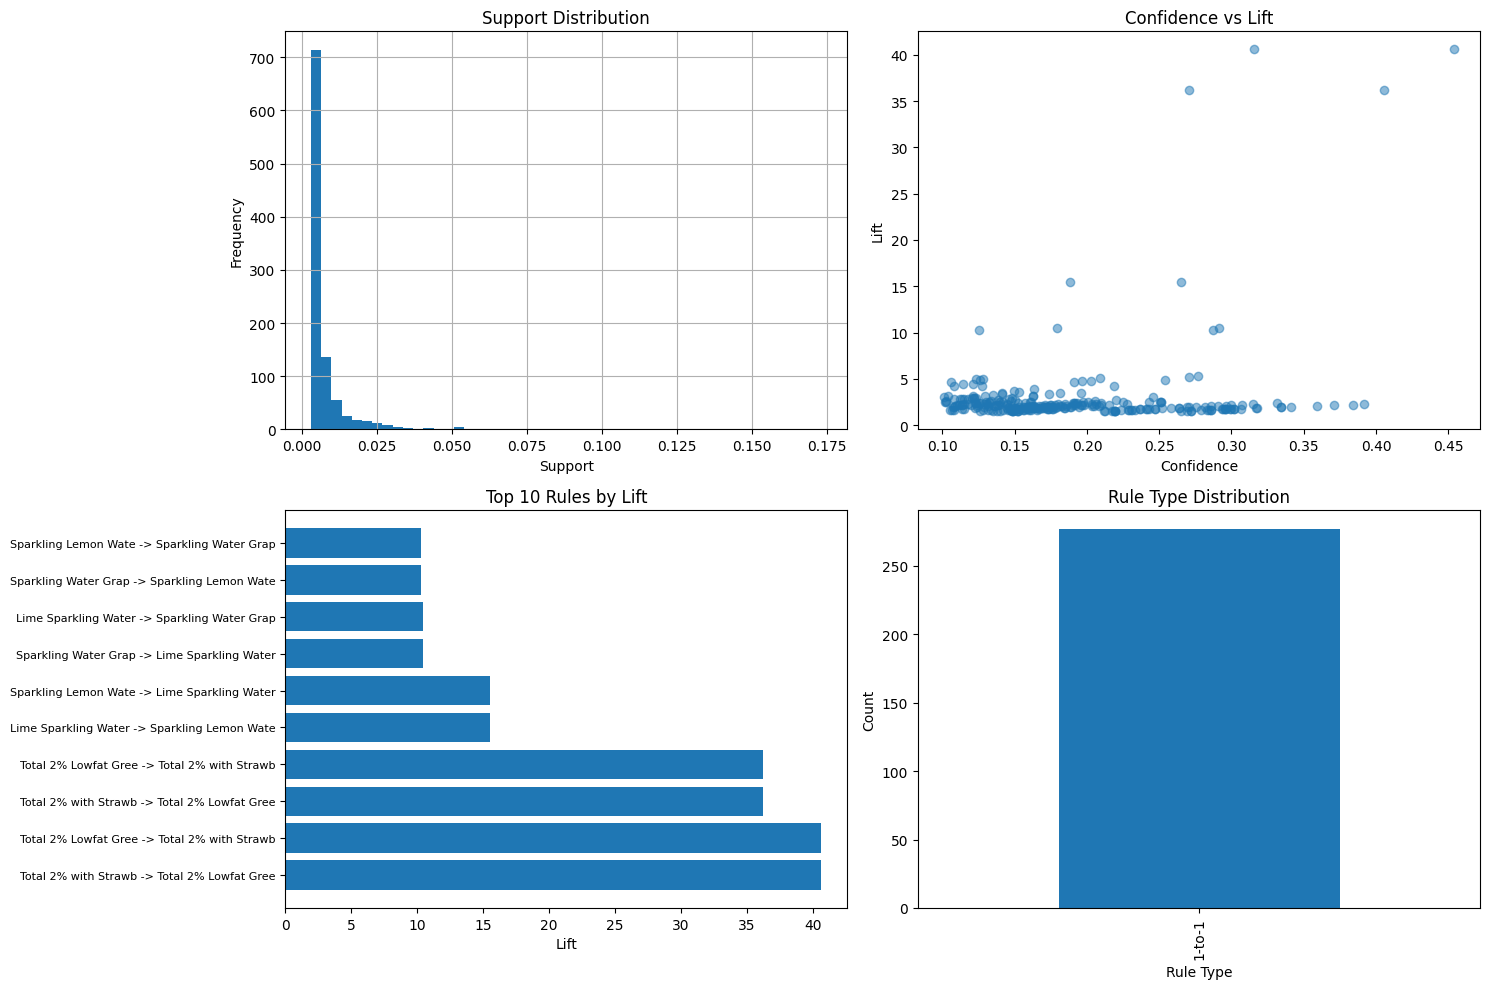

INFO:src.models.association_rules:Model saved to ../models/association_rule_model.pkl



✓ Model saved to models/association_rule_model.pkl
✓ Rules saved to data/processed/association_rules.csv


In [5]:
# ====================== Visualizations ======================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1) Support distribution
model.frequent_itemsets["support"].hist(bins=50, ax=axes[0, 0])
axes[0, 0].set_title("Support Distribution")
axes[0, 0].set_xlabel("Support")
axes[0, 0].set_ylabel("Frequency")

# 2) Confidence vs Lift
if len(rules_pairs) > 0:
    axes[0, 1].scatter(rules_pairs["confidence"], rules_pairs["lift"], alpha=0.5)
    axes[0, 1].set_title("Confidence vs Lift")
    axes[0, 1].set_xlabel("Confidence")
    axes[0, 1].set_ylabel("Lift")

# 3) Top 10 rules by lift
top_10 = rules_pairs.head(10)
axes[1, 0].barh(range(len(top_10)), top_10["lift"].values)
axes[1, 0].set_yticks(range(len(top_10)))
axes[1, 0].set_yticklabels(
    [f"{r['ante_name'][:20]} -> {r['cons_name'][:20]}" for _, r in top_10.iterrows()],
    fontsize=8
)
axes[1, 0].set_xlabel("Lift")
axes[1, 0].set_title("Top 10 Rules by Lift")

# 4) Rule length distribution
if len(model.rules) > 0:
    rule_dist = (
        model.rules.groupby(["ante_len", "cons_len"])
        .size()
        .reset_index(name="count")
    )
    rule_dist["type"] = rule_dist["ante_len"].astype(str) + "-to-" + rule_dist["cons_len"].astype(str)
    rule_dist.plot(x="type", y="count", kind="bar", ax=axes[1, 1], legend=False)
    axes[1, 1].set_title("Rule Type Distribution")
    axes[1, 1].set_xlabel("Rule Type")
    axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.savefig("../metrics/association_rules_analysis.png", dpi=300)
plt.show()

# ====================== Save Model ======================
model.save("../models/association_rule_model.pkl")
print("\n✓ Model saved to models/association_rule_model.pkl")

# Save rules to CSV
rules_pairs.to_csv("../data/processed/association_rules.csv", index=False)
print("✓ Rules saved to data/processed/association_rules.csv")